In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import warnings

from sklearn.datasets import make_blobs, make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
##Извлечем информацию из файла

dtrain = pd.read_csv('/home/volkov/hard_mnist/hard_train.txt', header = None, sep = '\\s+')
dlabels = pd.read_csv('/home/volkov/hard_mnist/hard_train_labels.txt', header = None, sep = '\\s+')

In [12]:
X_train = np.array(dtrain[:10000])
y_train = np.array(dlabels[:10000])

X_test = np.array(dtrain[10000:11000])
y_test = np.array(dlabels[10000:11000])

Запустим PCA на 2-х компонентах. И визуализируем полученный результат. Можно заметить, что для некоторых классов объекты кучкуются вместе. А некоторые сильно смешались. Что может ухудшить качество классификации.

In [12]:
pca_result = PCA(n_components=2).fit_transform(X_train)

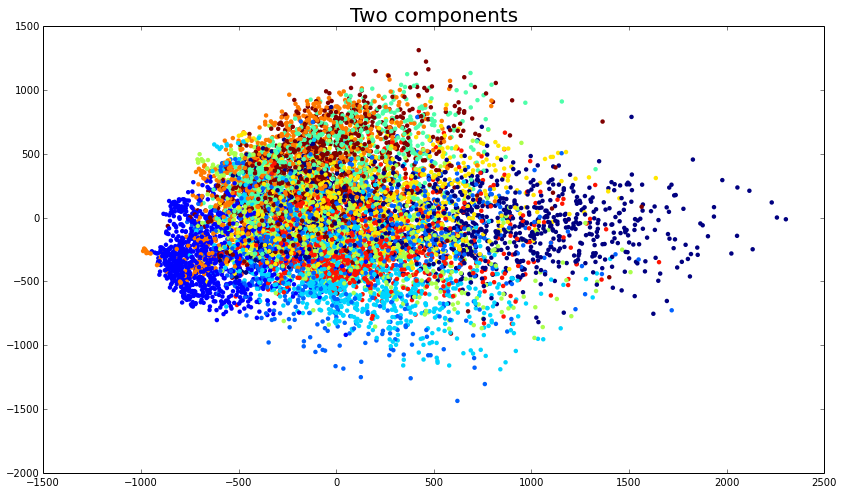

In [15]:
plt.figure(figsize=(14,8))
plt.title("Two components", fontsize=20)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_train, linewidths=0)
plt.show()

Метод PCA_algorithm принимает на вход обучающую выборку, тестовую выборку, количество компонент, на которые следует спроецировать пространство, а так же пути куда записать результат сжатия исходного пространнства. В случае если один из путей указан не был, функция вернет кортеж с результатами, иначе запишет в указанные файлы и вернет None.

In [5]:
def PCA_algorithm(X_train, X_test, n_components, file_path_train=None, file_path_test=None):
    pca = PCA(n_components=n_components).fit(X_train)
    pca_result_train = pca.transform(X_train)
    pca_result_test = pca.transform(X_test)
    if file_path_train and file_path_test:
        pd.DataFrame(pca_result_train).to_csv(file_path_train, sep=' ', index=False, header=False, mode='a')
        pd.DataFrame(pca_result_test).to_csv(file_path_test, sep=' ', index=False, header=False, mode='a')
    else: return(pca_result_train, pca_result_test)

Здесь запускаем PCA для 20 разных компонент и результат записываем в PCA_output.

In [5]:
for n in range(1, 21):
    PCA_algorithm(X_train, X_test, n, 'PCA_output/PCA_train{}.txt'.format(n), 'PCA_output/PCA_test{}.txt'.format(n))

Функция knn_algorithm принимает на вход обучающую и тестовую выборку, а так же ответы на тестовой и обучающей 
выборке, в kargs содержатся все настраиваемые параметры для KNeighborsClassifier. Данная функция возвращает долю неправильно классифицированных объектов и время работы алгоритма.

In [10]:
def knn_algorithm(X_train, y_train, X_test, y_test, **kargs):
    start = time.time()
    model = KNeighborsClassifier(**kargs)
    model.fit(X_train, y_train)
    fraction_misclassifications = zero_one_loss(y_test, model.predict(X_test))
    end = time.time()
    return(fraction_misclassifications, end-start)

Запускаем KNN на всех ранее сжатых пространствах. Результат записываем в соответсвующие директории.

In [7]:
for pca_number in range(1, 21):
    X_pca_train = pd.read_csv('PCA_output/PCA_train{}.txt'.format(pca_number), header = None, sep = '\\s+')
    X_pca_test = pd.read_csv('PCA_output/PCA_test{}.txt'.format(pca_number), header = None, sep = '\\s+')
    result = []
    for neighbors in range(1, 21):
        error_with_time = knn_algorithm(X_pca_train, y_train, X_pca_test, y_test, n_neighbors=neighbors, algorithm='brute')
        result.append(error_with_time)
    pd.DataFrame(result).to_csv('PCA_output/knn_PCA{}.txt'.format(pca_number), sep=' ', index=False, header=False, mode='a')

Изобразим матрицы качества и времени работы в зависимости от 𝑑 и 𝑘. Для этого создадим функцию, которая принимает 2 матрицы, а возвращает объект их визуализирующий.

In [8]:
def time_accuracy_matrix_plot(accuracy, time):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 8))
    ax1.imshow(accuracy, interpolation='none')
    ax1.set_title('Accuracy', fontsize=15)
    ax2.imshow(time, interpolation='none')
    ax2.set_title('Time', fontsize=15)
    return(plt)

In [5]:
time, accuracy = [], []
for pca_number in range(1, 21):
    f = pd.read_csv('PCA_output/knn_PCA{}.txt'.format(pca_number), header = None, sep = '\\s+')
    accuracy.append(1 - np.array(f[:][0]))
    time.append(np.array(f[:][1]))

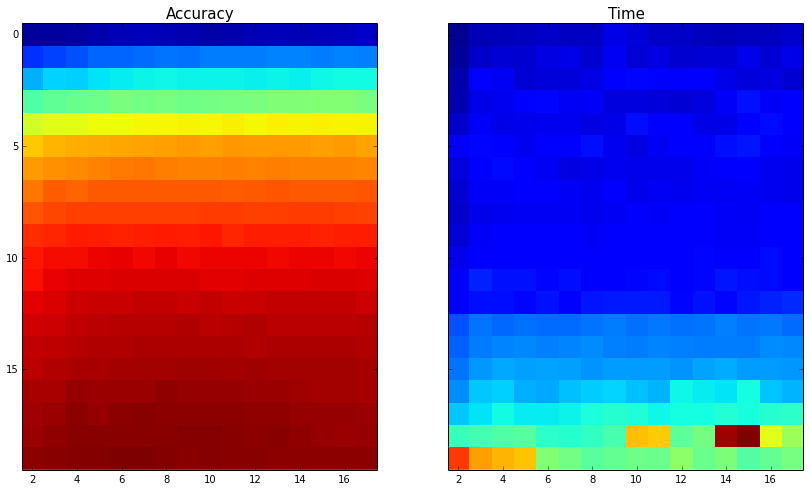

In [11]:
matrix_plot = time_accuracy_matrix_plot(accuracy, time)
matrix_plot.show()

Так как данные получались зашумленные проведем 5 разбиений исходной выборки и для всех повторим предыдущие действия.

In [7]:
step = 10000
test_size = 1000
for k in range(0, 5):
    X_train = np.array(dtrain[step*k:step*(k+1)])
    X_test = np.array(dtrain[step*(k+1):step*(k+1)+test_size])
    for n in range(1, 21):
        PCA_algorithm(X_train, X_test, n, 'PCA_output{}/PCA_train{}.txt'.format(k, n), 
                      'PCA_output{}/PCA_test{}.txt'.format(k, n))

In [23]:
step = 10000
test_size = 1000
for data_set_number in range(0, 5):
    y_train = np.array(dlabels[step*data_set_number:step*(data_set_number+1)])
    y_test = np.array(dlabels[step*(data_set_number+1):step*(data_set_number+1)+test_size])
    for pca_number in range(1, 21):
        X_pca_train = pd.read_csv('PCA_output{}/PCA_train{}.txt'.format(data_set_number, 
                                                                        pca_number), header = None, sep = '\\s+')
        X_pca_test = pd.read_csv('PCA_output{}/PCA_test{}.txt'.format(data_set_number,
                                                                      pca_number), header = None, sep = '\\s+')
        result = []
        for neighbors in range(1, 21):
            error_with_time = knn_algorithm(X_pca_train, y_train, X_pca_test, y_test, n_neighbors=neighbors, algorithm='brute')
            result.append(error_with_time)
        pd.DataFrame(result).to_csv('PCA_output{}/knn_PCA{}.txt'.format(data_set_number, pca_number), sep=' ',
                                    index=False, header=False, mode='a')

Усредним полученные данные.

In [35]:
for knn_number in range(1, 21):
    average = np.array(pd.read_csv('PCA_output{}/knn_PCA{}.txt'.format(0, knn_number),
                                   header = None, sep = '\\s+'))
    for data_set_number in range(1, 5):
        average += np.array(pd.read_csv('PCA_output{}/knn_PCA{}.txt'.format(data_set_number, knn_number),
                                 header = None, sep = '\\s+'))
    pd.DataFrame(average/5).to_csv('PCA_output_average/knn_PCA_average{}.txt'.format(knn_number), sep=' ',
                                    index=False, header=False, mode='a')

Изобразим матрицы качества и времени работы в зависимости от 𝑑 и 𝑘. Можно заметить что изображения стали более сглаженными.

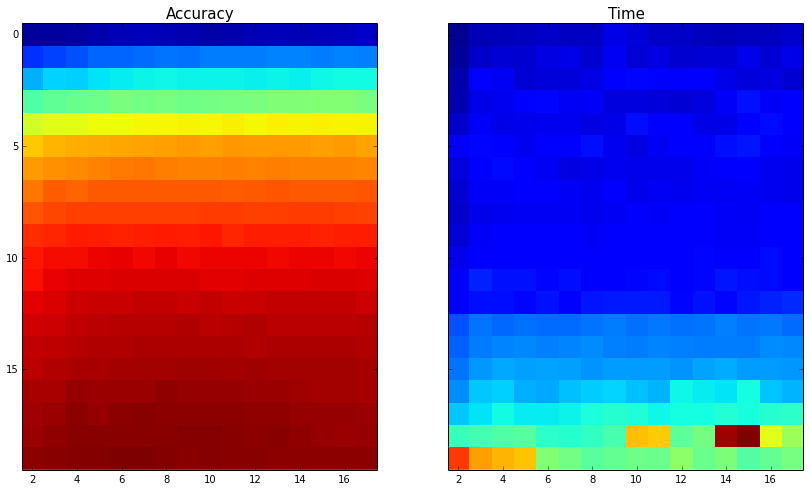

In [12]:
time, accuracy = [], []
for pca_number in range(1, 21):
    f = pd.read_csv('PCA_output_average/knn_PCA_average{}.txt'.format(pca_number), header = None, sep = '\\s+')
    accuracy.append(1 - np.array(f[:][0]))
    time.append(np.array(f[:][1]))

matrix_plot = time_accuracy_matrix_plot(accuracy, time)
matrix_plot.show()

Допольнительная визуализация. На самом деле после прогонки KNN на сжатых данных, было бы логичтно визуализировать полученные результаты так, как мы это делали в пунтке 1. Когда обучали KNN на несжатых данных. И по идее вид кривой и доля ошибок на большом количестве компонент не должны сильно отличаться. В этом мы сейчас и убедимся.

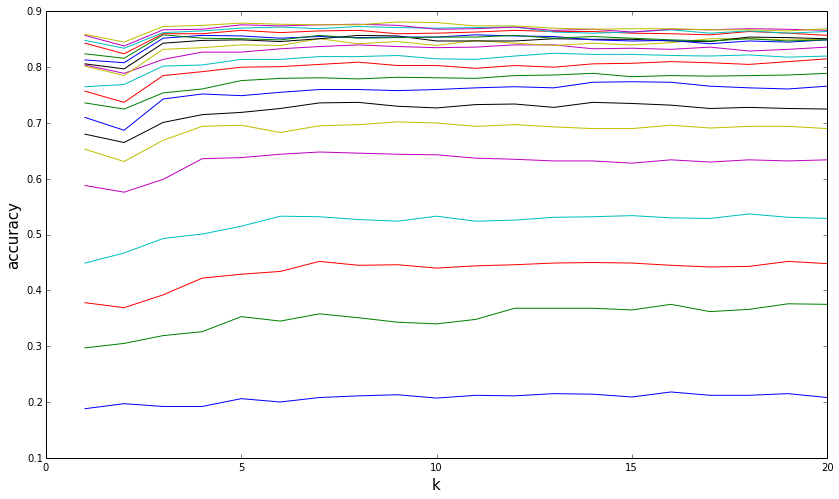

In [80]:
plt.figure(figsize=(14,8))
plt.ylabel("accuracy", fontsize=15)
plt.xlabel("k", fontsize=15)

k = range(1, 21)

for i in range(1, 21):
    f = pd.read_csv('PCA_output/knn_PCA{}.txt'.format(i), header = None, sep = '\\s+')
    accuracy = 1 - np.array(f[:][0])
    plt.plot(k, accuracy)
    
plt.show()

По графику выше можно сделать вывод, что самая точная классификация(88.5%) достигается у PCA c 20 компонентами на 9 соседях.

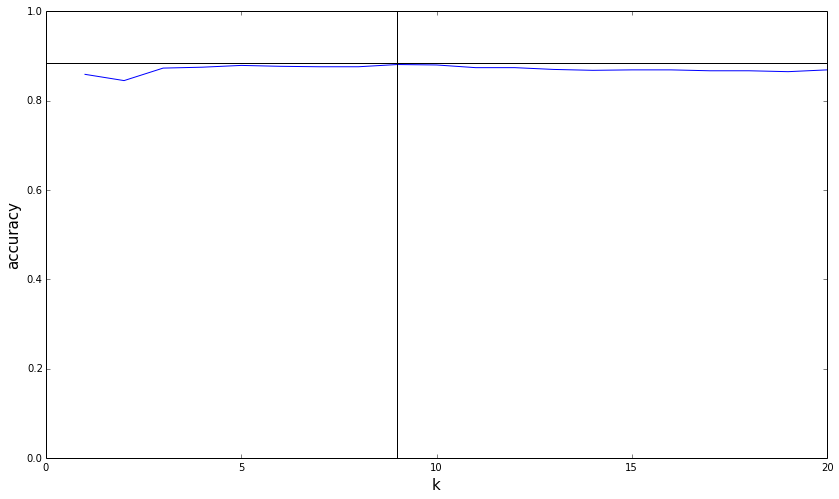

In [82]:
plt.figure(figsize=(14,8))
plt.ylabel("accuracy", fontsize=15)
plt.xlabel("k", fontsize=15)

f = pd.read_csv('PCA_output/knn_PCA{}.txt'.format(20), header = None, sep = '\\s+')
accuracy = 1 - np.array(f[:][0])
plt.plot(k, accuracy)
plt.plot([9, 9], [0, 1], 'k-')
plt.plot([0, 20], [0.885, 0.885], 'k-')
plt.show()

Аналогично можно изобразить на данных, которые мы получили после усреднения.

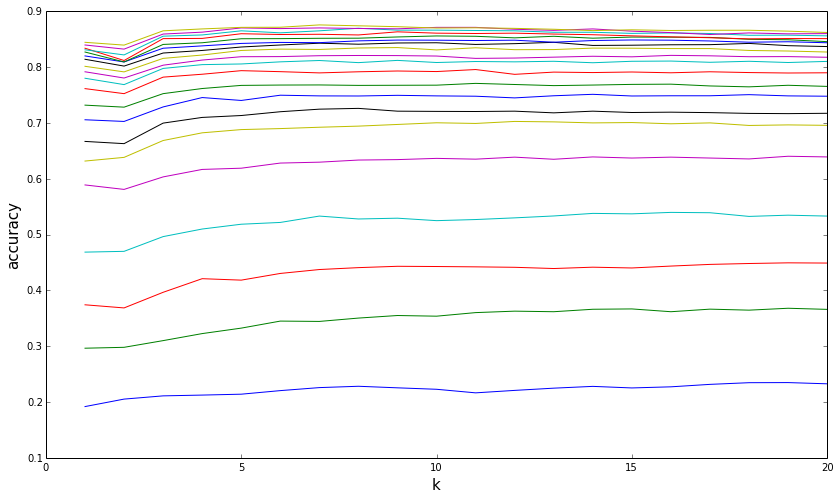

In [87]:
plt.figure(figsize=(14,8))
plt.ylabel("accuracy", fontsize=15)
plt.xlabel("k", fontsize=15)

k = range(1, 21)

for i in range(1, 21):
    f = pd.read_csv('PCA_output_average/knn_PCA_average{}.txt'.format(i), header = None, sep = '\\s+')
    accuracy = 1 - np.array(f[:][0])
    plt.plot(k, accuracy)
    
plt.show()

По данному графику можно заметить аналогичную тенденцию сглаживания. Что довольно логично, так как теперь мы уже не так чувствительны к шуму. Лучший результат(88%) достигается у PCA с 20 компонентами на 7 соседях.

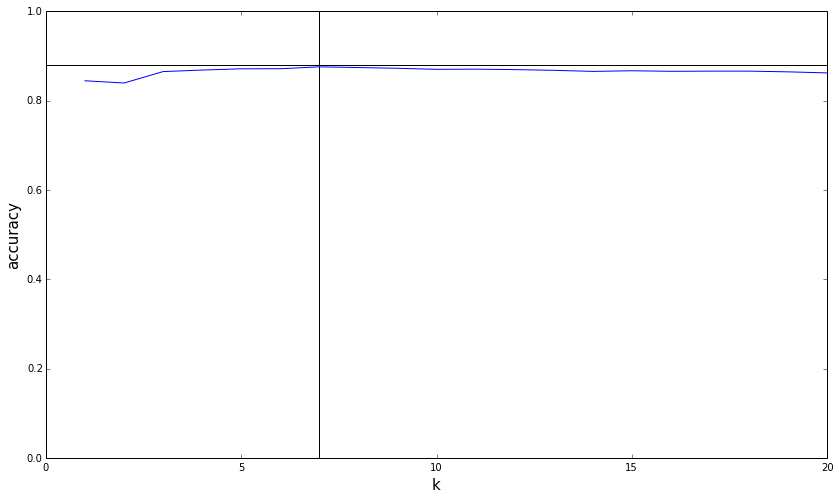

In [89]:
plt.figure(figsize=(14,8))
plt.ylabel("accuracy", fontsize=15)
plt.xlabel("k", fontsize=15)

f = pd.read_csv('PCA_output_average/knn_PCA_average{}.txt'.format(20), header = None, sep = '\\s+')
accuracy = 1 - np.array(f[:][0])
plt.plot(k, accuracy)

plt.plot([7, 7], [0, 1], 'k-')
plt.plot([0, 20], [0.88, 0.88], 'k-')
plt.show()